<a href="https://colab.research.google.com/github/soumya-r13/secure-encryption-with-adversarial-neural-cryptography/blob/main/Alice_Bob_Eve_(lstm%20only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
import numpy as np
import matplotlib.pyplot as plt

# Data Generation

## Defining the function

In [2]:
def generate_data(batch_size, seq_length):
    messages = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    keys = np.random.choice([-1, 1], size=(batch_size, seq_length, 1)).astype(np.float32)
    return messages, keys

## Parameters for Data Generation

In [3]:
batch_size = 64
seq_length = 128
train_size = 1000
test_size = 200

## Generating training and testing data

In [4]:
train_messages, train_keys = generate_data(train_size, seq_length)
test_messages, test_keys = generate_data(test_size, seq_length)

# Defining the Neural Networks

## Alice's Neural Network

In [5]:
def build_encryption_net():
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

## Bob's Neural Network

In [6]:
def build_decryption_net():
    model = models.Sequential()
    model.add(layers.Conv1D(seq_length, 3, padding='same', input_shape=(None, 2)))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(32, activation='relu')))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model

## Eve's Neural Network

In [7]:
def build_lstm_adversary_net():
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))
    return model


## Loss Functions

In [8]:
def separation(alice_input, bob_output):
    separation_value = tf.reduce_sum(tf.abs(tf.subtract(alice_input, bob_output)), axis=1)
    # print("separation", separation_value.numpy())
    return separation_value

def eve_vs_random_guess(alice_input, eve_output):
    loss = tf.square(seq_length/2 - separation(alice_input, eve_output)) / (seq_length/2) ** 2
    # print("Eve vs random guess loss:", loss.numpy())
    return tf.reduce_mean(loss)

def combined_loss_function(alice_input, decipher_bob, eve_output):
    loss = separation(alice_input, decipher_bob)/seq_length + eve_vs_random_guess(alice_input, eve_output)
    # print("Combined loss function:", loss.numpy())
    return tf.reduce_mean(loss)

def attacker_loss(alice_input, eve_output):
    loss = separation(alice_input, eve_output)
    # print("Attacker loss:", loss.numpy())
    return tf.reduce_mean(loss)

## Instantiating and compiling the Neural Networks

In [9]:
alice = build_encryption_net()
bob = build_decryption_net()
eve_lstm = build_lstm_adversary_net()

In [10]:
optimizer_ab = optimizers.Adam(learning_rate=0.0008)
optimizer_e_lstm = optimizers.Adam(learning_rate=0.0008)
optimizer_e_cnn_lstm = optimizers.Adam(learning_rate=0.0008)

## Training and Testing

In [11]:
num_epochs = 500

train_losses_ab_list = []
train_losses_e_lstm_list = []
test_losses_ab_list = []
test_losses_e_lstm_list = []

for epoch in range(num_epochs):
    with tf.GradientTape() as tape_ab:
        combined_input = tf.concat([train_messages, train_keys], axis=-1)
        ciphertext = alice(combined_input)

        decrypted_input = tf.concat([ciphertext, train_keys], axis=-1)
        decrypted_messages = bob(decrypted_input)

        loss_ab = combined_loss_function(train_messages, decrypted_messages, eve_lstm(ciphertext))

    gradients_ab = tape_ab.gradient(loss_ab, alice.trainable_variables + bob.trainable_variables)
    optimizer_ab.apply_gradients(zip(gradients_ab, alice.trainable_variables + bob.trainable_variables))

    with tf.GradientTape() as tape_e_lstm:

        guessed_messages_lstm = eve_lstm(ciphertext)

        loss_e_lstm = attacker_loss(train_messages, guessed_messages_lstm)

    gradients_e_lstm = tape_e_lstm.gradient(loss_e_lstm, eve_lstm.trainable_variables)
    optimizer_e_lstm.apply_gradients(zip(gradients_e_lstm, eve_lstm.trainable_variables))

    train_losses_ab_list.append(loss_ab.numpy())
    train_losses_e_lstm_list.append(loss_e_lstm.numpy())

    test_ciphertext = alice(tf.concat([test_messages, test_keys], axis=-1))
    test_decrypted_messages = bob(tf.concat([test_ciphertext, test_keys], axis=-1))
    test_guessed_messages_lstm = eve_lstm(test_ciphertext)

    test_loss_ab = combined_loss_function(test_messages, test_decrypted_messages, test_guessed_messages_lstm)
    test_loss_e_lstm = attacker_loss(test_messages, test_guessed_messages_lstm)

    test_losses_ab_list.append(test_loss_ab.numpy())
    test_losses_e_lstm_list.append(test_loss_e_lstm.numpy())

    print(f"Epoch {epoch + 1}: "
          f"Loss Alice-Bob: {test_loss_ab.numpy()},    Loss Eve: {test_loss_e_lstm.numpy()}")

Epoch 1: Loss Alice-Bob: 1.998734951019287,    Loss Eve: 127.76820373535156
Epoch 2: Loss Alice-Bob: 1.9987889528274536,    Loss Eve: 127.7603530883789
Epoch 3: Loss Alice-Bob: 1.998824954032898,    Loss Eve: 127.75157928466797
Epoch 4: Loss Alice-Bob: 1.9988445043563843,    Loss Eve: 127.74166870117188
Epoch 5: Loss Alice-Bob: 1.9988473653793335,    Loss Eve: 127.73043823242188
Epoch 6: Loss Alice-Bob: 1.9988503456115723,    Loss Eve: 127.71774291992188
Epoch 7: Loss Alice-Bob: 1.9988595247268677,    Loss Eve: 127.70343780517578
Epoch 8: Loss Alice-Bob: 1.9988746643066406,    Loss Eve: 127.68739318847656
Epoch 9: Loss Alice-Bob: 1.9989066123962402,    Loss Eve: 127.66958618164062
Epoch 10: Loss Alice-Bob: 1.9989707469940186,    Loss Eve: 127.650146484375
Epoch 11: Loss Alice-Bob: 1.9990899562835693,    Loss Eve: 127.62943267822266
Epoch 12: Loss Alice-Bob: 1.999293565750122,    Loss Eve: 127.60808563232422
Epoch 13: Loss Alice-Bob: 1.999611496925354,    Loss Eve: 127.5871353149414
Epo

# Plotting

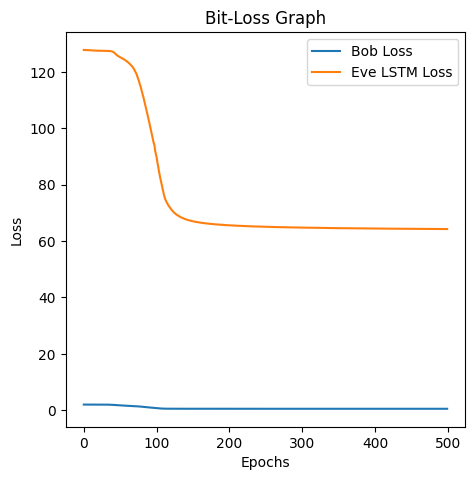

In [12]:
plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.plot(test_losses_ab_list, label='Bob Loss')
plt.plot(test_losses_e_lstm_list, label='Eve LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Bit-Loss Graph')
plt.legend()

plt.tight_layout()
plt.show()